In [3]:
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import plotly.plotly as py
from plotly import tools
from datetime import date
import pandas as pd
from pandas import DataFrame
import numpy as np 
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
#from imblearn import *
#from imblearn.over_sampling import SMOTE, ADASYN
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns
import random 
import warnings
import operator
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

import scipy as sp

import copy

In [4]:
rawdata = pd.read_csv("train.csv")

In [5]:
rawdata.head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,...,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW


In [529]:
print ("결측치 표시기")
missmap = rawdata.isnull().sum().to_frame().sort_values(0, ascending = False)
missmap[missmap[0] != 0]

결측치 표시기


,0
WindDirection,80234
WindSpeed,67430
Temperature,48532
GameWeather,43648
StadiumType,32934
FieldPosition,6424
Humidity,6160
OffenseFormation,110
DefendersInTheBox,66
Orientation,18


## 전체 데이터 구조

In [4]:
# 컬럼명 탐색

rawdata.columns

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'Yards', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')

In [64]:
rawdata.head().iloc[:,0:10]

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31


In [65]:
rawdata.head().iloc[:,10:20]

,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance
0,496723,Eric Berry,29,2017,35,1,14:14:00,NE,3,2
1,2495116,Allen Bailey,97,2017,35,1,14:14:00,NE,3,2
2,2495493,Justin Houston,50,2017,35,1,14:14:00,NE,3,2
3,2506353,Derrick Johnson,56,2017,35,1,14:14:00,NE,3,2
4,2530794,Ron Parker,38,2017,35,1,14:14:00,NE,3,2


In [66]:
rawdata.head().iloc[:,20:30]

,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff
0,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z
1,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z
2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z
3,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z
4,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z


In [67]:
rawdata.head().iloc[:,30:40]

,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week
0,2017-09-08T00:44:05.000Z,8,6-0,212,12/29/1988,Tennessee,SS,NE,KC,1
1,2017-09-08T00:44:05.000Z,8,6-3,288,03/25/1989,Miami,DE,NE,KC,1
2,2017-09-08T00:44:05.000Z,8,6-3,270,01/21/1989,Georgia,DE,NE,KC,1
3,2017-09-08T00:44:05.000Z,8,6-3,245,11/22/1982,Texas,ILB,NE,KC,1
4,2017-09-08T00:44:05.000Z,8,6-0,206,08/17/1987,Newberry,FS,NE,KC,1


In [68]:
rawdata.head().iloc[:,40:]

,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
0,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
2,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
3,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
4,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW


In [31]:
# 한번의 플레이당(즉 동일 PlayID)당 22개의 선수들이 하나로 묶여서 경기를 진행
# 즉, 분석을 위해선 22개 행의 단위로 GROUP을 지어서 분석을 실시할 필요가 있음

rawdata[rawdata["PlayId"] == rawdata["PlayId"][0]][["GameId","PlayId","Team","DisplayName","TimeHandoff","Position"]].head(30)

,GameId,PlayId,Team,DisplayName,TimeHandoff,Position
0,2017090700,20170907000118,away,Eric Berry,2017-09-08T00:44:06.000Z,SS
1,2017090700,20170907000118,away,Allen Bailey,2017-09-08T00:44:06.000Z,DE
2,2017090700,20170907000118,away,Justin Houston,2017-09-08T00:44:06.000Z,DE
3,2017090700,20170907000118,away,Derrick Johnson,2017-09-08T00:44:06.000Z,ILB
4,2017090700,20170907000118,away,Ron Parker,2017-09-08T00:44:06.000Z,FS
5,2017090700,20170907000118,away,Dee Ford,2017-09-08T00:44:06.000Z,DE
6,2017090700,20170907000118,away,Terrance Mitchell,2017-09-08T00:44:06.000Z,CB
7,2017090700,20170907000118,away,Phillip Gaines,2017-09-08T00:44:06.000Z,CB
8,2017090700,20170907000118,away,Daniel Sorensen,2017-09-08T00:44:06.000Z,SS
9,2017090700,20170907000118,away,Marcus Peters,2017-09-08T00:44:06.000Z,CB


(array([1.88760e+04, 4.21322e+05, 5.63860e+04, 8.97600e+03, 2.04600e+03,
       1.01200e+03, 5.06000e+02, 4.62000e+02, 6.60000e+01, 1.10000e+02]), array([-14. ,  -2.7,   8.6,  19.9,  31.2,  42.5,  53.8,  65.1,  76.4,
        87.7,  99. ]), <a list of 10 Patch objects>)
509762


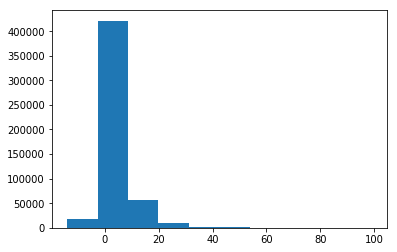

In [15]:
# 타겟변수 분포

print(plt.hist(rawdata["Yards"]))
print(rawdata["Yards"].count())

## 선수별 포지션 일람
### 각 변수별로 *22의 와이드폼으로 펼칠 때, 포지션별로 개별 할당이 가능한지 탐색

In [195]:
rawdata["Position"].unique()

array(['SS', 'DE', 'ILB', 'FS', 'CB', 'DT', 'WR', 'TE', 'T', 'QB', 'RB',
       'G', 'C', 'OLB', 'NT', 'FB', 'MLB', 'LB', 'OT', 'OG', 'HB', 'DB',
       'S', 'DL', 'SAF'], dtype=object)

In [531]:
# 몇몇 선수들은 하나 이상의 포지션을 맡은 것으로 보인다. 12만큼의 중복된 인원이 존재한다.

print("전체 선수들의 수")
print(len(rawdata["DisplayName"].unique()))
print("포지션 별 선수들의 수")
print(len(rawdata.groupby("DisplayName")["Position"].value_counts()))

전체 선수들의 수
2230
포지션 별 선수들의 수
2242


In [526]:
# 중복 포지션을 갖고있는 선수들 찾기

temp = DataFrame(rawdata.groupby("DisplayName")["Position"].value_counts()).unstack().unstack().unstack()

for i in range(0,len(temp.T)):
    if temp.isnull().iloc[:,i].value_counts()[0] != 1:
        print(temp.iloc[:,i].name)
        print(temp.iloc[:,i].Position.dropna().index.values)

Andre Smith
['LB' 'T']
Brandon Marshall
['ILB' 'WR']
Brandon Williams
['CB' 'DT' 'TE']
Chris Thompson
['RB' 'WR']
Isaiah Johnson
['DB' 'S']
Joe Thomas
['ILB' 'OT']
Kyle Fuller
['C' 'CB']
Marcus Williams
['CB' 'FS']
Michael Bennett
['DE' 'DT']
Michael Thomas
['SS' 'WR']
Nick Williams
['DT' 'WR']


In [57]:
# 한 번의 경기엔 여러개의 중복 포지션들이 존재함
# 선수의 수 = 22명
# 포지션의 수 = 13

rawdata[rawdata["PlayId"] == rawdata["PlayId"][1]]["Position"].value_counts()

DE     3
WR     3
CB     3
SS     2
G      2
T      2
QB     1
FS     1
C      1
TE     1
ILB    1
DT     1
RB     1
Name: Position, dtype: int64

In [146]:
rawdata["PlayId"].unique()

array([20170907000118, 20170907000139, 20170907000189, ...,
       20181230154082, 20181230154135, 20181230154157], dtype=int64)

In [148]:
rawdata[rawdata["PlayId"] == rawdata["PlayId"].unique()[1]][rawdata["Team"] == "away"]["X"]

22    65.73
23    66.04
24    66.02
25    63.31
26    60.51
27    66.60
28    65.12
29    65.18
30    48.05
31    64.46
32    66.80
Name: X, dtype: float64

# 경기 시작후 선수들의 위치 현황

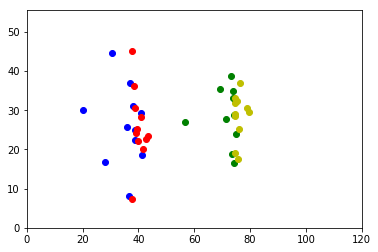

In [149]:
x_away_1 = rawdata[rawdata["PlayId"] == rawdata["PlayId"].unique()[0]][rawdata["Team"] == "away"]["X"]
y_away_1 = rawdata[rawdata["PlayId"] == rawdata["PlayId"].unique()[0]][rawdata["Team"] == "away"]["Y"]

x_home_1 = rawdata[rawdata["PlayId"] == rawdata["PlayId"].unique()[0]][rawdata["Team"] == "home"]["X"]
y_home_1 = rawdata[rawdata["PlayId"] == rawdata["PlayId"].unique()[0]][rawdata["Team"] == "home"]["Y"]

x_away_2 = rawdata[rawdata["PlayId"] == rawdata["PlayId"].unique()[5]][rawdata["Team"] == "away"]["X"]
y_away_2 = rawdata[rawdata["PlayId"] == rawdata["PlayId"].unique()[5]][rawdata["Team"] == "away"]["Y"]

x_home_2 = rawdata[rawdata["PlayId"] == rawdata["PlayId"].unique()[5]][rawdata["Team"] == "home"]["X"]
y_home_2 = rawdata[rawdata["PlayId"] == rawdata["PlayId"].unique()[5]][rawdata["Team"] == "home"]["Y"]

plt.xlim(0,120)
plt.ylim(0,55.5)
# 어웨이 팀의 위치
plt.scatter(x = x_away_1, y = y_away_1,c="g")
plt.scatter(x = x_home_1, y = y_home_1,c="y")
# 홈 팀의 위치
plt.scatter(x = x_away_2, y = y_away_2,c="b")
plt.scatter(x = x_home_2, y = y_home_2,c="r")

# 매 경기마다 시작위치가 달라진다

In [ ]:
# 시계열적 특성 = 선수는 갈수록 지칠것이다
# 매 iteration 자체의 특성 = 시작 위치, 속력, 각속도 등..

# 시작 위치와 골라인간의 직선거리(L2 Norm)을 고려(특성 엔지니어링)

# 두 개를 모두 고려한 모델을 생각해보자

# 데이터 전처리 - 카테고리 변수의 변환

# 데이터 전처리 - 결측치 처리

# 데이터 전처리 - 와이드폼 전환

Yards
-14    ([1.0, 0.0, 1.0, 1.0, 1.0, 3.0, 4.0, 2.0, 7.0,...
-12    ([15.0, 8.0, 12.0, 10.0, 2.0, 19.0, 0.0, 7.0, ...
-11    ([17.0, 3.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 9.0...
-10    ([17.0, 4.0, 13.0, 9.0, 10.0, 12.0, 1.0, 1.0, ...
-9     ([20.0, 39.0, 10.0, 15.0, 4.0, 1.0, 8.0, 51.0,...
-8     ([4.0, 20.0, 37.0, 18.0, 25.0, 12.0, 23.0, 14....
-7     ([5.0, 47.0, 142.0, 64.0, 26.0, 64.0, 100.0, 1...
-6     ([55.0, 40.0, 177.0, 164.0, 222.0, 132.0, 126....
-5     ([109.0, 207.0, 326.0, 334.0, 225.0, 264.0, 38...
-4     ([149.0, 385.0, 834.0, 878.0, 655.0, 689.0, 70...
-3     ([278.0, 521.0, 939.0, 1157.0, 1133.0, 1153.0,...
-2     ([462.0, 951.0, 1975.0, 1852.0, 1852.0, 2008.0...
-1     ([936.0, 1848.0, 2584.0, 2834.0, 2792.0, 3053....
 0     ([2390.0, 3091.0, 5201.0, 6065.0, 5829.0, 5772...
 1     ([2934.0, 4585.0, 6830.0, 7240.0, 7209.0, 7513...
 2     ([2028.0, 4632.0, 7876.0, 9285.0, 8733.0, 9368...
 3     ([1630.0, 4584.0, 7393.0, 8520.0, 7928.0, 7694...
 4     ([1479.0, 3638.0, 

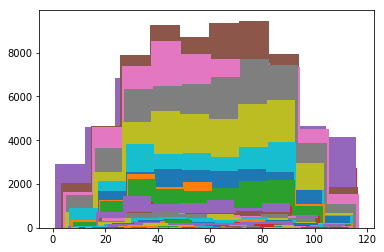

In [25]:
rawdata.groupby("Yards")["X"].apply(lambda x : plt.hist(x))

In [ ]:
## modeling
## 우선 22개 행의 변수들을 하나의 행인 WideForm으로 만든다
## 즉, 하나의 변수당 22개의 열들이 생긴다(X_1, X_2....X_22, Y_1,y_2,....Y_22 등)